In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from models import SingleScoreCNN

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

score_model = torch.load("simple_model.pth")

# # Alternatively, you can set requires_grad to False for each parameter in the model
# for param in score_model.parameters():
#     param.requires_grad = False

In [81]:
score_model

SingleScoreCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [82]:
def rgb_to_grayscale(image):
    # Coefficients for RGB to grayscale conversion
    rgb_weights = torch.tensor([0.2989, 0.5870, 0.1140]).view(3, 1, 1)
    
    # Convert to grayscale
    grayscale_image = torch.sum(image * rgb_weights, dim=1)
    
    return grayscale_image

In [83]:
class SimpleGenerator(nn.Module):
    def __init__(self, img_dim=[64,64]):
        super(SimpleGenerator, self).__init__()
        self.img_dim = img_dim
        self.fc = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, np.prod(img_dim))
        )
        
    def forward(self, x):
        out = self.fc(x)
        return out.view(-1, *self.img_dim)

# Example usage:
img_dim = (3,64, 64)  # Grayscale image of size 28x28
generator = SimpleGenerator(img_dim)
tmp_img = generator(torch.randn(100))

rgb_to_grayscale(tmp_img).shape

torch.Size([1, 64, 64])

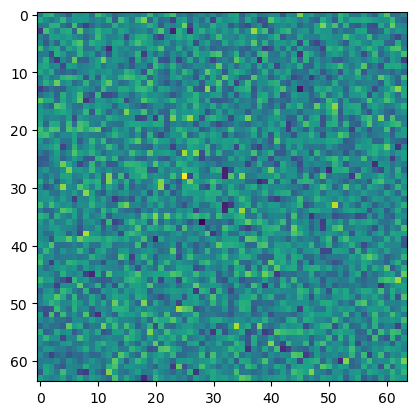

In [84]:
plt.imshow(rgb_to_grayscale(tmp_img).reshape(img_dim[1:]).detach().cpu().numpy())

In [85]:
score_model(tmp_img)

tensor([[0.2342]], grad_fn=<AddmmBackward0>)

Epoch [1/50], Loss: -1.4963
Epoch [2/50], Loss: -4.4994
Epoch [3/50], Loss: -4.4488
Epoch [4/50], Loss: -0.8767
Epoch [5/50], Loss: -0.6468
Epoch [6/50], Loss: -0.6503
Epoch [7/50], Loss: -0.6506
Epoch [8/50], Loss: -0.6507
Epoch [9/50], Loss: -0.6507
Epoch [10/50], Loss: -0.6508
Epoch [11/50], Loss: -0.6508
Epoch [12/50], Loss: -0.6509
Epoch [13/50], Loss: -0.6509
Epoch [14/50], Loss: -0.6509
Epoch [15/50], Loss: -0.6509
Epoch [16/50], Loss: -0.6509
Epoch [17/50], Loss: -0.6509
Epoch [18/50], Loss: -0.6509
Epoch [19/50], Loss: -0.6510
Epoch [20/50], Loss: -0.6510
Epoch [21/50], Loss: -0.6510
Epoch [22/50], Loss: -0.6510
Epoch [23/50], Loss: -0.6510
Epoch [24/50], Loss: -0.6510
Epoch [25/50], Loss: -0.6510
Epoch [26/50], Loss: -0.6510
Epoch [27/50], Loss: -0.6510
Epoch [28/50], Loss: -0.6510
Epoch [29/50], Loss: -0.6510
Epoch [30/50], Loss: -0.6510
Epoch [31/50], Loss: -0.6510
Epoch [32/50], Loss: -0.6510
Epoch [33/50], Loss: -0.6510
Epoch [34/50], Loss: -0.6510
Epoch [35/50], Loss: -0

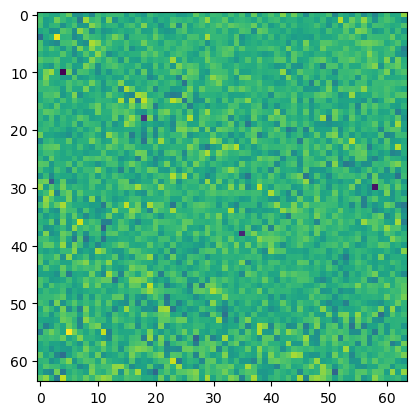

In [92]:
device = "mps"

score_model = score_model.to(device)
generator = generator.to(device)

# Training setup
optimizer = optim.Adam(generator.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_epochs = 50
batch_size = 32
target_score = torch.tensor(1.0)

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    for _ in range(batch_size):
        optimizer.zero_grad()

        # Generate random latent vector
        latent_vector = torch.randn(batch_size, 100).to(device)

        # Generate fake images
        fake_images = generator(latent_vector)

        predicted_scores = score_model(fake_images)
        
        # print(predicted_scores.shape)

        # Compute loss (compare predicted scores against the target score of 1)
        loss = (torch.log(abs(torch.ones(batch_size,1).to(device) - predicted_scores))).mean()
        
        # print(loss)

        loss.backward()
        score_model.zero_grad()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / batch_size
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    # print(predicted_scores)

# Visualize a generated image
latent_vector = torch.randn(1, 100).to(device)
generated_image = generator(latent_vector)
plt.imshow(rgb_to_grayscale(generated_image.detach().cpu()).reshape(img_dim[1:]))
plt.show()